### Introduction
This dataset contains historical sales data including holiday promotion events. The goal of this project is to forecast sales for the stores. The data is available for download here: https://www.kaggle.com/c/walmart-recruiting-store-sales-forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as matplot
from matplotlib import font_manager as fm
import seaborn as sns
import scipy.stats
import statsmodels.api as sm
import pprint
import warnings
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
warnings.filterwarnings("ignore")

%matplotlib inline

C:\Users\divya\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Data Exploration & Wrangling 

In [2]:
# Loading all files provided into dataframes
features = pd.read_csv('C:\\Users\\divya\\Documents\\git\\DataScienceTrack\\CapstoneProject 2-Walmart Sales Forecast\\features.csv')
stores = pd.read_csv('C:\\Users\\divya\\Documents\\git\\DataScienceTrack\\CapstoneProject 2-Walmart Sales Forecast\\stores.csv')
test = pd.read_csv('C:\\Users\\divya\\Documents\\git\\DataScienceTrack\\CapstoneProject 2-Walmart Sales Forecast\\test.csv',parse_dates=['Date'])
train = pd.read_csv('C:\\Users\\divya\\Documents\\git\\DataScienceTrack\\CapstoneProject 2-Walmart Sales Forecast\\train.csv',parse_dates=['Date'])
sample_sub = pd.read_csv('C:\\Users\\divya\\Documents\\git\\DataScienceTrack\\CapstoneProject 2-Walmart Sales Forecast\\sample_submission.csv')

In [3]:
print(features.head())

   Store        Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
0      1  2010-02-05        42.31       2.572        NaN        NaN   
1      1  2010-02-12        38.51       2.548        NaN        NaN   
2      1  2010-02-19        39.93       2.514        NaN        NaN   
3      1  2010-02-26        46.63       2.561        NaN        NaN   
4      1  2010-03-05        46.50       2.625        NaN        NaN   

   MarkDown3  MarkDown4  MarkDown5         CPI  Unemployment  IsHoliday  
0        NaN        NaN        NaN  211.096358         8.106      False  
1        NaN        NaN        NaN  211.242170         8.106       True  
2        NaN        NaN        NaN  211.289143         8.106      False  
3        NaN        NaN        NaN  211.319643         8.106      False  
4        NaN        NaN        NaN  211.350143         8.106      False  


Features file consists of the following columns
- Store
- Date
- Temperature
- Fuel Price
- Mark downs ( up to 5)
- CPI
- Unemployment
- Is Holiday

Though this information is very useful for data exploration and storytelling, for the purpose of this project I will be doing a time series forecast for which these features may not be utilized. These features will be useful for a Linear regression model.

In [4]:
print(stores.head())

   Store Type    Size
0      1    A  151315
1      2    A  202307
2      3    B   37392
3      4    A  205863
4      5    B   34875


This information is useful for data storytelling and machine learning models, but for time series forecasting we will not be using this.

In [5]:
print(train.head())

   Store  Dept       Date  Weekly_Sales  IsHoliday  Temperature  Fuel_Price  \
0     26    92 2011-08-26      87235.57      False        61.10       3.796   
1     34    22 2011-03-25       5945.97      False        53.11       3.480   
2     21    28 2010-12-03       1219.89      False        50.43       2.708   
3      8     9 2010-09-17      11972.71      False        75.32       2.582   
4     19    55 2012-05-18       8271.82      False        58.81       4.029   

   MarkDown1  MarkDown2  MarkDown3  MarkDown4  MarkDown5         CPI  \
0        NaN        NaN        NaN        NaN        NaN  136.213613   
1        NaN        NaN        NaN        NaN        NaN  128.616064   
2        NaN        NaN        NaN        NaN        NaN  211.265543   
3        NaN        NaN        NaN        NaN        NaN  214.878556   
4   12613.98        NaN       11.5    1705.28    3600.79  138.106581   

   Unemployment Type    Size  
0         7.767    A  152513  
1        10.398    A  158114  

This dataset is useful as it contains Weekly forecast by Store and department which will be used in the time series forecast.

In [6]:
# In this section I am looking at some high level information like number of stores, number of departments, start and end dates

print("The earliest date available for which weekly forecast is available is",train.Date.min())
print("The latest date available for which weekly forecast is available is",train.Date.max())

weeks=pd.date_range(train.Date.min(),train.Date.max(),freq='7D')

print('Number of weeks between {0} and {1} is {2}'.format(train.Date.min(),train.Date.max(),len(weeks)))

print("Number of stores in the training dataset are:",train.Store.nunique())
print("Number of Departments across all stores in the training dataset are:",train.Dept.nunique())

The earliest date available for which weekly forecast is available is 2010-02-05 00:00:00
The latest date available for which weekly forecast is available is 2012-10-26 00:00:00
Number of weeks between 2010-02-05 00:00:00 and 2012-10-26 00:00:00 is 143
Number of stores in the training dataset are: 45
Number of Departments across all stores in the training dataset are: 81


The dataset weekly forecasts for 45 stores and 81 departments overall. The next step is to identify missing data and methods to handle them.

## Missing data

We observed that there are 81 unique departments across all stores. Let's see if these departments exist across all stores.

In [7]:
print("Top 10 stores sorted by number of departments",train.groupby('Store').Dept.nunique().nlargest(10))

print("Bottom 10 stores sorted by number of departments",train.groupby('Store').Dept.nunique().nsmallest(10))

Top 10 stores sorted by number of departments Store
19    79
2     78
11    78
13    78
15    78
27    78
1     77
4     77
6     77
10    77
Name: Dept, dtype: int64
Bottom 10 stores sorted by number of departments Store
36    60
33    61
38    61
42    61
43    61
37    62
44    62
30    64
3     70
5     72
Name: Dept, dtype: int64


Looks like all departments don't exist across all stores. Our goal is to forecast sales at the department level, so it is not necessary for all stores to have all departments. Now let's see if data for consecutive weeks is available for all departments. There are 182 weeks between the earliest week and latest week in the dataset.If there is no missing information, all departments in all stores must have sales forecasts for 182 weeks.

In [8]:
print("Top 5 departments sorted by number of available weeks",train.groupby(['Store','Dept']).Weekly_Sales.count().nlargest(5))
print("Bottom 5 departments sorted by number of available weeks",train.groupby(['Store','Dept']).Weekly_Sales.count().nsmallest(5))

Top 5 departments sorted by number of available weeks Store  Dept
27     24      116
25     59      115
11     27      114
8      90      113
17     2       113
Name: Weekly_Sales, dtype: int64
Bottom 5 departments sorted by number of available weeks Store  Dept
2      39      1
3      77      1
5      78      1
6      77      1
7      78      1
Name: Weekly_Sales, dtype: int64


Clearly, several weeks are missing from the data. It looks like some departments have only one week's sales available. Let's look at one sample department in a store. I am using Store 1 and department 1 as an example.

In [9]:
print(train[(train.Store==1) & (train.Dept==1)].sort_values(by=['Date'])[['Store','Dept','Date','Weekly_Sales']].head(20))

        Store  Dept       Date  Weekly_Sales
124083      1     1 2010-02-12      46039.49
171280      1     1 2010-02-26      19403.54
52982       1     1 2010-03-05      21827.90
266036      1     1 2010-03-12      21043.39
135904      1     1 2010-04-02      57258.43
128503      1     1 2010-04-09      42960.91
61940       1     1 2010-04-16      17596.96
27090       1     1 2010-04-30      16555.11
228625      1     1 2010-05-07      17413.94
193220      1     1 2010-05-14      18926.74
267520      1     1 2010-05-21      14773.04
259739      1     1 2010-06-11      16637.62
220817      1     1 2010-06-18      16216.27
51157       1     1 2010-06-25      16328.72
131264      1     1 2010-07-02      16333.14
4231        1     1 2010-07-09      17688.76
157599      1     1 2010-07-16      17150.84
198066      1     1 2010-07-30      15381.82
209978      1     1 2010-08-13      15536.40
75068       1     1 2010-08-27      15793.87


In this example, we can clearly see that there are missing weeks in the data. For example between 3/12/2010 and 4/2/2010 there are two weeks missing. Between 4/2/2010 and 4/9/2010, there is no missing weeks

### Approach

To begin with, I will be developing forecast model for a single department and later scale to other departments. I am going use Store 1's Department 1 as my sample department. 

At a high level, here are the steps I am going to follow for the sample model

1. Fill any missing data
2. Test for random walk by running Augmented Dickey fuller test
3. Take first difference to transform into a stationary series
4. Compute ACF and PACF
5. Using ACF and PACF as a guide, fit a few AR, MA, and ARMA models
6. Use AIC/BIC to choose best model
7. Using the best model forecast the future

### Time Series forecast for a single department

### 1. Fill missing data

            Weekly_Sales
Date                    
2010-02-12      46039.49
2010-02-19      46039.49
2010-02-26      19403.54
2010-03-05      21827.90
2010-03-12      21043.39
2012-09-28 00:00:00
2010-02-12 00:00:00


(array([733804., 733924., 734046., 734169., 734289., 734411., 734534.,
        734655., 734777.]), <a list of 9 Text xticklabel objects>)

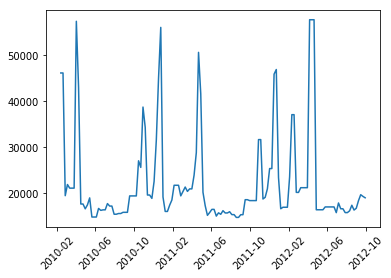

In [10]:
store1_dept1=train[(train.Store==1)&(train.Dept==1)]
store1_dept1.sort_values(by=['Date'])
#store1_dept1_up=store1_dept1.apply(lambda x: x.set_index('Date').resample('W-FRI',fill_method='ffill'))

store1_dept1.set_index('Date',inplace=True)
store1_dept1=store1_dept1.resample('W-FRI',fill_method='ffill')
store1_dept1_up_week_sales=store1_dept1.loc[:,['Weekly_Sales']]
print(store1_dept1_up_week_sales.head())
print(store1_dept1_up_week_sales.index.max())
print(store1_dept1_up_week_sales.index.min())


plt.figure(1)
#plt.figure(figsize=(20,15))
plt.plot(store1_dept1_up_week_sales['Weekly_Sales'])
plt.xticks(rotation=45)

### 2. Test  for Random walk

In [11]:
from statsmodels.tsa.stattools import adfuller

results=adfuller(store1_dept1_up_week_sales['Weekly_Sales'])

print(results)
print('The p-value of the augmented dickey fuller test on Weekly sales is: ' + str(results[1]))

(-7.202987186432617, 2.3391280119533315e-10, 1, 136, {'1%': -3.4793722137854926, '5%': -2.8830370378332995, '10%': -2.578233635380623}, 2537.0756633547107)
The p-value of the augmented dickey fuller test on Weekly sales is: 2.3391280119533315e-10


The t-statistic is lower that the critical values, hence we can reject the null hypothesis that the series is a random walk.

### 3. Transform into a stationary series

As we cannot reject the hypothesis that the weekly sales time series is a random walk, we can say that the time series is non stationary. Random walks and seasonality are good examples of non stationary series. It is impossible to forecast random walk, so we have to transform the series into a stationary series. Random walks can be easily transformed into a stationary series by taking the first difference. Seasonality can be removed by taking seasonal differences. However because of the noise we cannot tell if there is any trend or seasonality in the data. In the section below we will be using some techniques like Aggregation, Smoothing, Polynomial fitting to eliminate the noise so we can see some trend in the data.

#### First difference with single lag

(array([733804., 733924., 734046., 734169., 734289., 734411., 734534.,
        734655., 734777.]), <a list of 9 Text xticklabel objects>)

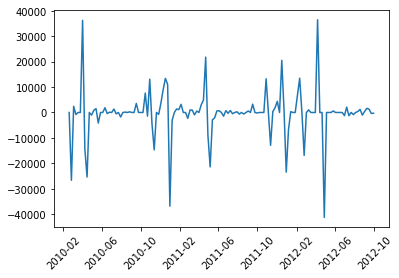

In [12]:
plt.figure(1)
#plt.figure(figsize=(20,15))
store1_dept1_up_week_sales_diff=store1_dept1_up_week_sales['Weekly_Sales'].diff()
plt.plot(store1_dept1_up_week_sales_diff.dropna())
plt.xticks(rotation=45)

We can do the dickey fuller test to check if this series is a random walk.

In [13]:
results_diff=adfuller(store1_dept1_up_week_sales_diff.dropna())

print(results_diff)

(-9.043363640622246, 5.0630003285417894e-15, 5, 131, {'1%': -3.481281802271349, '5%': -2.883867891664528, '10%': -2.5786771965503177}, 2544.3356983492426)


The null hypothesis is that the series is non stationary. Since the t statistic is less than the critical values, we can reject the null hypothesis and conclude that the series is stationary. Now we can also try the method of decomposing the series into three components Trend, Seasonality and residuals. We can test for stationarity on the residuals.

#### Decomposing

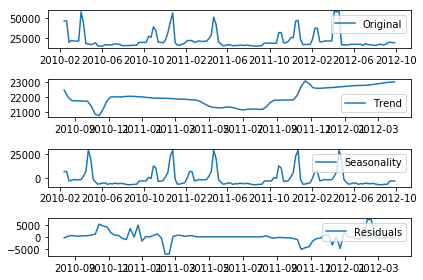

In [14]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(store1_dept1_up_week_sales)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(store1_dept1_up_week_sales, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Let us check stationarity of residuals

In [15]:
results_res=adfuller(residual['Weekly_Sales'])

print(results_res)

LinAlgError: SVD did not converge

We can reject the hypothesis that the residuals after decomposing the time series is non-stationary.

## 3. Compute ACF and PACF

Let's check the autocorrelation of the weekly timeseries. Autocorrelation is the correlation of a timeseries with a lagged copy or copies of itself.

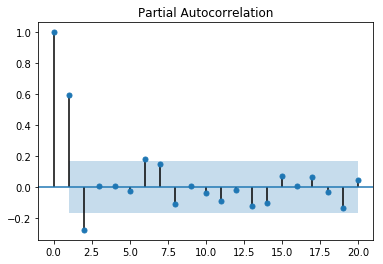

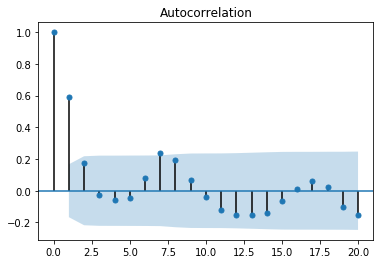

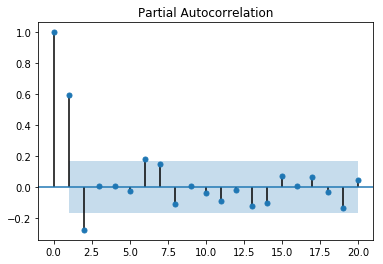

In [22]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

plot_acf(store1_dept1_up_week_sales['Weekly_Sales'],lags=20,alpha=0.05)
plot_pacf(store1_dept1_up_week_sales['Weekly_Sales'],lags=20,alpha=0.05)

#### ACF is gradually declining to zero and there is a sharp cut off of PACF after lag 2 indicating an AR(2) model. We can also check for the BIC to determine the order. For the MA term we can look at the ACF which shows that the MA term is also 2.

In [ ]:
# Import the module for estimating an ARMA model
from statsmodels.tsa.arima_model import ARMA

# Fit the data to an AR(p) for p = 0,...,6 , and save the BIC
BIC = np.zeros(10)
for p in range(10):
    mod = ARMA(store1_dept1_up_week_sales['Weekly_Sales'], order=(p,0))
    res = mod.fit()
# Save BIC for AR(p)    
    BIC[p] = res.bic
    
# Plot the BIC as a function of p
plt.plot(range(1,10), BIC[1:10], marker='o')
plt.xlabel('Order of AR Model')
plt.ylabel('Baysian Information Criterion')
plt.show()

#### It looks like AR-2 model gives the lowest BIC.

## AR model
Since the original series itself looked stationary and the ACF and PACF indicated an AR model. We can 

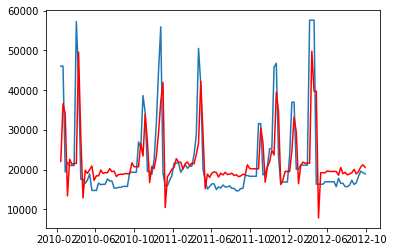

In [25]:
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(store1_dept1_up_week_sales, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(store1_dept1_up_week_sales)
plt.plot(results_AR.fittedvalues, color='red')
#plt.title(sum((results_AR.fittedvalues-ts_log_diff)**2))

### ARMA model

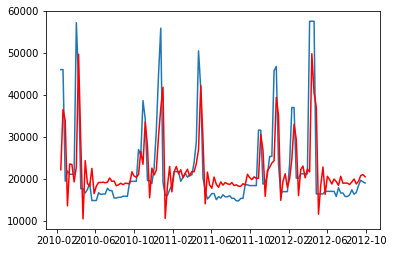

In [27]:
model = ARIMA(store1_dept1_up_week_sales, order=(2, 0, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(store1_dept1_up_week_sales)
plt.plot(results_ARIMA.fittedvalues, color='red')
#plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

## Forecasting

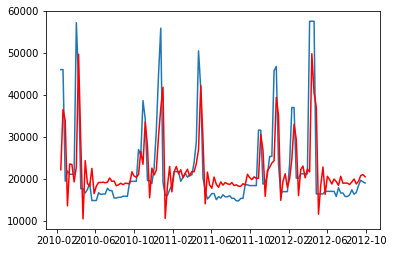

In [29]:
predictions_ARIMA = pd.Series(results_ARIMA.fittedvalues, copy=True)

plt.plot(store1_dept1_up_week_sales)
plt.plot(predictions_ARIMA,color='r')
#plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA_log-store1_dept1_up_week_sales)**2)/len(ts)))



In [ ]:
Consulted References:
    Time series analysis
    https://www.youtube.com/watch?v=Prpu_U5tKkE&t=406s

In [ ]:
To do:
    
    Simple regression using features
    figure out why the moving average and exponential average 